Paper reference: https://arxiv.org/pdf/1707.02131.pdf

- Focus on *offline* signature-verification which is *writer-independent*.
- Challenging as compared to other one-shot tasks because writing styles could greatly differ.

In [ ]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip BHSig260.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patool
import patoolib


     |████████████████████████████████| 77 kB 1.6 MB/s eta 0:00:01


In [ ]:
import copy
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import ImageOps

In [ ]:
base_dir = "BHSig260/Bengali"
class_range = np.arange(1, 101)
os.mkdir("processed_signatures/")

for i in class_range:
  os.mkdir("processed_signatures/" + str(i))

In [ ]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

def _get_img_paths():
  for sigclass in os.listdir(base_dir):
    class_path = os.path.join(base_dir, sigclass)
    if class_path == "BHSig260/Bengali/Bengali_pairs.txt" or class_path == "BHSig260/Bengali/list.forgery" or class_path == "BHSig260/Bengali/list.genuine":
      continue
    for image in os.listdir(class_path):
      if image.endswith(".tif"):
        yield os.path.join(class_path, image)

def preprocess_signature(img_path):
  signer = img_path.split("/")[-1].split("-")[-3]
  image = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)

  if image is None:
    print(f"The image {img_path} cannot be read. Skipping")
    return

  image = cv2.resize(image, (155, 220), interpolation=cv2.INTER_LINEAR)
  image = cv2.bitwise_not(image)
  filename = os.path.join("processed_signatures", f"{signer}")

  if(img_path.split("/")[-1].split("-")[-2]=='F'):
    dum="forgeries_"+img_path.split("/")[-1].split("-")[-1]
    filename=os.path.join(filename,dum)
  if(img_path.split("/")[-1].split("-")[-2]=='G'):
    dum="original_"+img_path.split("/")[-1].split("-")[-1]
    filename=os.path.join(filename,dum)

  cv2.imwrite(filename, image)

for img_path in _get_img_paths():
  preprocess_signature(img_path)

In [ ]:
!ls processed_signatures/1 | wc -l

54


In [ ]:
def make_pairs(images, labels):

  assert len(images) == len(labels)

  genuine_combinations = list(itertools.combinations(images[labels == 1], 2))
  forged_combinations = [[image1, image0] for image1 in images[labels == 1]
              for image0 in images[labels == 0]]
  forged_combinations = random.sample(forged_combinations, 276)
  pair_images = np.concatenate((genuine_combinations, forged_combinations))
  pair_labels = np.concatenate(([1] * len(genuine_combinations), [0] * len(forged_combinations)))

  return pair_images, pair_labels


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".tif"):
            img = cv2.imread(os.path.join(folder, filename), 0)
            if img is not None:
                images.append(img)
                labels.append(int(filename.split("_")[0] == "original"))
    return np.array(images), np.array(labels)

def train_test(root_dir, k=50):
    trainx, trainy, testx, testy = [], [], [], []
    
    all_signers = os.listdir(root_dir)
    train_signers = np.random.choice(all_signers, k, replace=False)
    test_signers = list(set(all_signers) - set(train_signers))

    for signer in train_signers:
        current_signer_images, current_signer_labels = load_images_from_folder(os.path.join(root_dir, signer))
        current_pair_images, current_pair_labels = make_pairs(current_signer_images, current_signer_labels)
        trainx.append(current_pair_images)
        trainy.append(current_pair_labels)

    for signer in test_signers:
        current_signer_images, current_signer_labels = load_images_from_folder(os.path.join(root_dir, signer))
        current_pair_images, current_pair_labels = make_pairs(current_signer_images, current_signer_labels)
        testx.append(current_pair_images)
        testy.append(current_pair_labels)

    trainx = np.concatenate(trainx).reshape(-1, 2, 220, 155)
    testx = np.concatenate(testx).reshape(-1, 2, 220, 155)
    trainy = np.concatenate(trainy).reshape(-1, 1)
    testy = np.concatenate(testy).reshape(-1, 1)

    return trainx, trainy, testx, testy

trainx, trainy, testx, testy = train_test("processed_signatures")


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
class SignatureVerificationDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.transforms = transforms
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        img0 = self.images[idx][0]
        img1 = self.images[idx][1]

        img0 = Image.fromarray(img0).convert('L')
        img1 = Image.fromarray(img1).convert('L')

        if self.transforms:
            img0 = self.transforms(img0)
            img1 = self.transforms(img1)

        return img0, img1, self.labels[idx]

    def __len__(self):
        return self.images.shape[0]


In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize((155, 220)),
    ImageOps.invert,
    transforms.ToTensor(),
    transforms.Normalize([0.449], [0.226]),
])
train_signature_dataset = SignatureVerificationDataset(trainx, trainy,transforms=transforms_)


In [ ]:
def imshow(img):
  plt.figure(figsize=(20, 6))
  img = img.permute(1, 2, 0)
  img = img.numpy()
  plt.imshow((img * 255).astype(np.uint8))
  plt.show()

In [ ]:
train_loader = DataLoader(
    train_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=8
)
dataiter = iter(train_loader)
print(dataiter)


In [ ]:
test_signature_dataset = SignatureVerificationDataset(testx, testy,transforms=transforms_)
test_loader = DataLoader(
    test_signature_dataset,
    shuffle=True,
    num_workers=2,
    batch_size=1,
)

In [ ]:
class SigNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    # No. of kernels = No. of out channels (each channel is convolved independently).
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(108800, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.lrn = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout1 = nn.Dropout2d(0.3)
    self.dropout2 = nn.Dropout2d(0.3)

    self.conv_relu_pool_norm = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout2d(0.3),
    )
    self.fc = nn.Sequential(
        nn.Linear(108800, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
    )

  def forward_single(self, x):
    x = self.conv_relu_pool_norm(x)
    x = x.view(x.size()[0], -1)
    x = self.fc(x)
    return x

  def forward(self, x1, x2):
    out1 = self.forward_single(x1)
    out2 = self.forward_single(x2)

    return out1, out2

svn = SigNet()
svn = svn.to(device)

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = ContrastiveLoss()
optimizer = optim.RMSprop(svn.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)

scheduler = lr_scheduler.StepLR(optimizer, step_size=8)

epochs = 1

In [ ]:
counter = []
iteration_number = 0
loss_history = [] 

svn.train()
for epoch in range(epochs):
  for i, data in enumerate(train_loader, 0):
    img0, img1, label = data
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    optimizer.zero_grad()
    output1, output2 = svn(img0, img1)
    loss_contrastive = criterion(output1, output2, label)
    loss_contrastive.backward()
    optimizer.step()
    if i % 20 == 0 :
      print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
      iteration_number += 20
      counter.append(iteration_number)
      loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 0.49993494153022766

Epoch number 0
 Current loss 61.28382873535156

Epoch number 0
 Current loss 0.4999886751174927

Epoch number 0
 Current loss 0.5000237226486206

Epoch number 0
 Current loss 0.7064563035964966

Epoch number 0
 Current loss 0.39277029037475586

Epoch number 0
 Current loss 0.5294216871261597

Epoch number 0
 Current loss 0.8179461359977722

Epoch number 0
 Current loss 0.6449569463729858

Epoch number 0
 Current loss 0.5672774314880371

Epoch number 0
 Current loss 0.5474773049354553

Epoch number 0
 Current loss 0.22225379943847656

Epoch number 0
 Current loss 0.39298397302627563

Epoch number 0
 Current loss 0.2612532377243042

Epoch number 0
 Current loss 0.3280699849128723

Epoch number 0
 Current loss 0.18650062382221222

Epoch number 0
 Current loss 0.2648085951805115

Epoch number 0
 Current loss 0.4510192573070526

Epoch number 0
 Current loss 0.36354702711105347

Epoch number 0
 Current loss 0.40454912185668945

Epoch number 0

In [ ]:
torch.save(svn.state_dict(), "svn.pth")

In [ ]:
model = SignatureVerificationNetwork().to(device)
model.load_state_dict(torch.load("svn.pth"))

<All keys matched successfully>

In [ ]:
# Util
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose((npimg * 255).astype(np.uint8), (1, 2, 0)))
    plt.show() 

tensor([0.4308], device='cuda:0', grad_fn=<NormBackward1>)


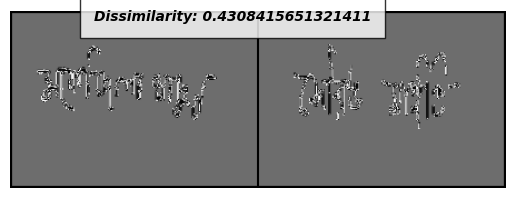

tensor([0.5128], device='cuda:0', grad_fn=<NormBackward1>)


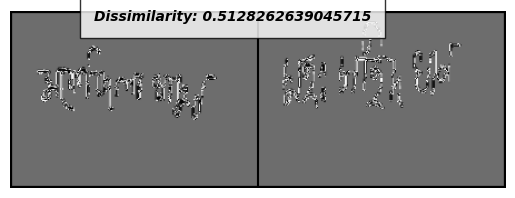

tensor([0.4239], device='cuda:0', grad_fn=<NormBackward1>)


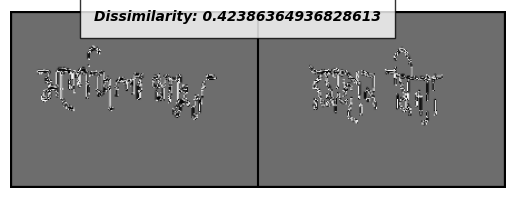

tensor([0.3897], device='cuda:0', grad_fn=<NormBackward1>)


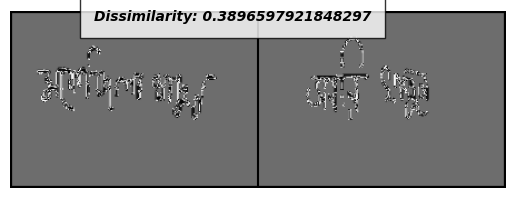

tensor([0.5455], device='cuda:0', grad_fn=<NormBackward1>)


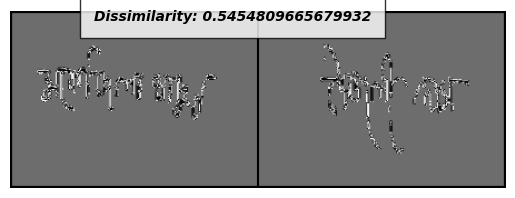

tensor([0.4553], device='cuda:0', grad_fn=<NormBackward1>)


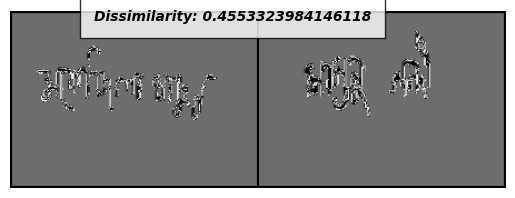

tensor([0.6026], device='cuda:0', grad_fn=<NormBackward1>)


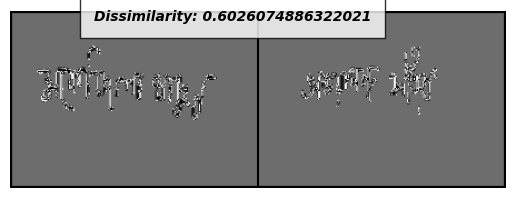

tensor([0.5164], device='cuda:0', grad_fn=<NormBackward1>)


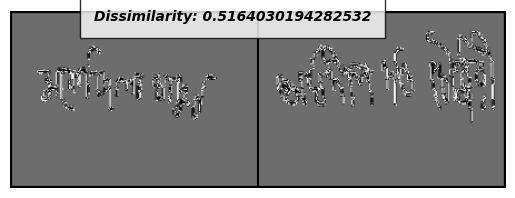

tensor([0.5558], device='cuda:0', grad_fn=<NormBackward1>)


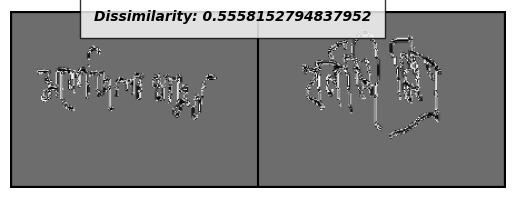

tensor([0.5857], device='cuda:0', grad_fn=<NormBackward1>)


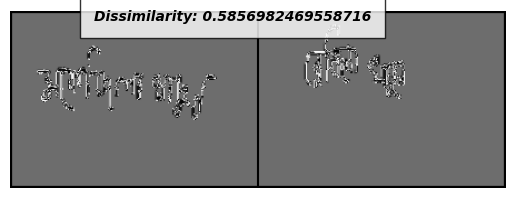

In [ ]:
dataiter = iter(test_loader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1, output2 = model(x0.to(device), x1.to(device))
    print(F.pairwise_distance(output1, output2))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f"Dissimilarity: {euclidean_distance.item()}")

In [ ]:
def accuracy(distances, y, step=0.01):
    min_threshold_d = min(distances)
    max_threshold_d = max(distances)
    max_acc = 0
    same_id = (y == 1)
    same_id_1= (y==0)

    for threshold_d in torch.arange(min_threshold_d, max_threshold_d+step, step):
        true_positive = (distances <= threshold_d) & (same_id)
        true_positive_rate = len(true_positive) / len(same_id)
        true_negative = (distances > threshold_d) & (same_id_1)
        true_negative_rate = len(true_negative) / len(same_id_1)

        acc = 0.5 * (true_negative_rate + true_positive_rate)
        max_acc = max(max_acc, acc)
    return max_acc


In [ ]:
model.eval()
running_loss = 0
number_samples = 0

distances = []

for batch_idx, (x1, x2, y) in enumerate(test_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)

    x1, x2 = model(x1, x2)
    loss = criterion(x1, x2, y)
    distances.extend(zip(torch.pairwise_distance(x1, x2, 2).cpu().tolist(), y.cpu().tolist()))

    number_samples += len(x1)
    running_loss += loss.item() * len(x1)

    if (batch_idx + 1) % 50 == 0 or batch_idx == len(test_loader) - 1:
        print('{}/{}: Loss: {:.4f}'.format(batch_idx+1, len(test_loader), running_loss / number_samples))

distances, y = zip(*distances)
distances, y = torch.tensor(distances), torch.tensor(y)
max_accuracy = accuracy(distances, y)
print(f'Max accuracy: {max_accuracy}')
print(running_loss / number_samples)

50/27600: Loss: 0.5123
100/27600: Loss: 0.5513
150/27600: Loss: 0.5133
200/27600: Loss: 0.5107
250/27600: Loss: 0.4860
300/27600: Loss: 0.4806
350/27600: Loss: 0.4860
400/27600: Loss: 0.4820
450/27600: Loss: 0.4847
500/27600: Loss: 0.4835
550/27600: Loss: 0.4856
600/27600: Loss: 0.4894
650/27600: Loss: 0.4868
700/27600: Loss: 0.4816
750/27600: Loss: 0.4823
800/27600: Loss: 0.4788
850/27600: Loss: 0.4750
900/27600: Loss: 0.4738
950/27600: Loss: 0.4697
1000/27600: Loss: 0.4727
1050/27600: Loss: 0.4736
1100/27600: Loss: 0.4751
1150/27600: Loss: 0.4758
1200/27600: Loss: 0.4738
1250/27600: Loss: 0.4768
1300/27600: Loss: 0.4798
1350/27600: Loss: 0.4848
1400/27600: Loss: 0.4850
1450/27600: Loss: 0.4859
1500/27600: Loss: 0.4859
1550/27600: Loss: 0.4833
1600/27600: Loss: 0.4799
1650/27600: Loss: 0.4786
1700/27600: Loss: 0.4784
1750/27600: Loss: 0.4783
1800/27600: Loss: 0.4787
1850/27600: Loss: 0.4817
1900/27600: Loss: 0.4819
1950/27600: Loss: 0.4831
2000/27600: Loss: 0.4829
2050/27600: Loss: 0.